In [29]:
import numpy as np
import torch
import local_utils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from local_utils import ResidualBlock
from torch import nn
import cv2
from pathlib import Path
from collections import OrderedDict
from types import SimpleNamespace
import torch.quantization
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os

image_size = (270, 270)

# 1. Dane ewaluacyjne

Liczba obrazów w zbiorze testowym: 6


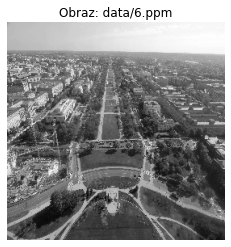

In [2]:
class SuperPointDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_paths = [str(f) for f in Path(image_folder).iterdir() if f.suffix == ".ppm"]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, image_size)
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]

transform = transforms.Compose([transforms.ToTensor()])

test_dataset = SuperPointDataset("./data", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(f"Liczba obrazów w zbiorze testowym: {len(test_dataset)}")
# Wyświetlanie jednego obrazu z test_loader
image, path = test_dataset[0]  # Wybieramy pierwszy obraz
image = image.squeeze(0)  # Usuwamy wymiar kanału (1, H, W)
image = image.numpy()  # Konwertujemy tensor na numpy array

# Wyświetlanie obrazu
plt.imshow(image, cmap='gray')
plt.title(f"Obraz: {path}")
plt.axis('off')  # Ukrycie osi
plt.show()

# 2. Inicjalizacja modelu zmiennoprzecinkowego

In [3]:
def sample_descriptors(keypoints, descriptors, s: int = 8):
    """Interpolate descriptors at keypoint locations"""
    b, c, h, w = descriptors.shape
    keypoints = (keypoints + 0.5) / (keypoints.new_tensor([w, h]) * s)
    keypoints = keypoints * 2 - 1  # normalize to (-1, 1)
    descriptors = torch.nn.functional.grid_sample(
        descriptors, keypoints.view(b, 1, -1, 2), mode="bilinear", align_corners=False
    )
    descriptors = torch.nn.functional.normalize(
        descriptors.reshape(b, c, -1), p=2, dim=1
    )
    return descriptors


def batched_nms(scores, nms_radius: int):
    assert nms_radius >= 0

    def max_pool(x):
        return torch.nn.functional.max_pool2d(
            x, kernel_size=nms_radius * 2 + 1, stride=1, padding=nms_radius
        )

    zeros = torch.zeros_like(scores)
    max_mask = scores == max_pool(scores)
    for _ in range(2):
        supp_mask = max_pool(max_mask.float()) > 0
        supp_scores = torch.where(supp_mask, zeros, scores)
        new_max_mask = supp_scores == max_pool(supp_scores)
        max_mask = max_mask | (new_max_mask & (~supp_mask))
    return torch.where(max_mask, scores, zeros)


def select_top_k_keypoints(keypoints, scores, k):
    if k >= len(keypoints):
        return keypoints, scores
    scores, indices = torch.topk(scores, k, dim=0, sorted=True)
    return keypoints[indices], scores


class VGGBlock(nn.Sequential):
    def __init__(self, c_in, c_out, kernel_size, relu=True):
        padding = (kernel_size - 1) // 2
        conv = nn.Conv2d(
            c_in, c_out, kernel_size=kernel_size, stride=1, padding=padding
        )
        activation = nn.ReLU(inplace=True) if relu else nn.Identity()
        bn = nn.BatchNorm2d(c_out, eps=0.001)
        super().__init__(
            OrderedDict(
                [
                    ("conv", conv),
                    ("activation", activation),
                    ("bn", bn),
                ]
            )
        )
    
class SuperPoint_short(nn.Module):
    default_conf = {
        "nms_radius": 4,
        "max_num_keypoints": 500,
        "detection_threshold": 0.005,
        "remove_borders": 4,
        "descriptor_dim": 256,
        "channels": [64, 64, 128, 128, 256],
    }

    def __init__(self, **conf):
        super().__init__()
        conf = {**self.default_conf, **conf}
        self.conf = conf
        self.stride = 2 ** (len(self.conf["channels"]) - 2)
        channels = [1, *self.conf["channels"][:-1]]

        # Definicja QuantStub
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

        backbone = []
        for i, c in enumerate(channels[1:], 1):
            layers = [VGGBlock(channels[i - 1], c, 3), VGGBlock(c, c, 3)]
            if i < len(channels) - 1:
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            backbone.append(nn.Sequential(*layers))
        self.backbone = nn.Sequential(*backbone)

        c = self.conf["channels"][-1]
        self.detector = nn.Sequential(
            VGGBlock(channels[-1], c, 3),
            VGGBlock(c, self.stride**2 + 1, 1, relu=False),
        )
        self.descriptor = nn.Sequential(
            VGGBlock(channels[-1], c, 3),
            VGGBlock(c, self.conf["descriptor_dim"], 1, relu=False),
        )

    def forward(self, data):
        # Kwantyzacja wejścia
        image = self.quant(data)

        features = self.backbone(image)
        descriptors_dense = self.descriptor(features)

        # Decode the detection scores
        scores = self.detector(features)
        # Dekwantyzacja przed wyjściem
        return self.dequant(scores), self.dequant(descriptors_dense)


In [4]:
device = torch.device("cpu")
detection_thresh = 0.005
nms_radius = 5

float_model = SuperPoint_short(detection_threshold=detection_thresh, nms_radius=nms_radius).eval()
float_model.load_state_dict(torch.load("model_weights_legacy.pth"))
conf = float_model.conf
input_shape = (1, 1, image_size[1], image_size[0])
model = float_model.to(device)

print(device)

cpu


# Inspector model

In [5]:
import pytorch_nndct
print(pytorch_nndct.__version__)
from pytorch_nndct.apis import Inspector
target = "DPUCZDX8G_ISA1_B4096"

inspector = Inspector(target)
rand_in = torch.randn(input_shape)
inspector.inspect(model, (rand_in,), device=device, output_dir="inspect", image_format="png")

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'

[VAIQ_NOTE]: Loading NNDCT kernels...
0.1.0+09b3f3d

[VAIQ_NOTE]: =>Inspector is initialized successfully with target:
name: DPUCZDX8G_ISA1_B4096
type: DPUCZDX8G
isa_version: 1

[VAIQ_NOTE]: =>Start to inspect model...

[VAIQ_NOTE]: =>Quant Module is in 'cpu'.

[VAIQ_NOTE]: =>Parsing SuperPoint_short...

[VAIQ_NOTE]: Start to trace model...

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 39/39 [00:00<00:00, 590.02it/s, OpInfo: name = return_0, type = Return]                    


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(inspect/SuperPoint_short.py)



[VAIQ_NOTE]: All the operators are assigned to the DPU(see more details in 'inspect/inspect_DPUCZDX8G_ISA1_B4096.txt')

[VAIQ_NOTE]: Dot image is generated.(inspect/inspect_DPUCZDX8G_ISA1_B4096.png)

[VAIQ_NOTE]: =>Finish inspecting.


# Postprocessing

In [16]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(torch.__version__)

detection_thresh = 0.005
nms_radius = 5

def match_descriptors(kp1, desc1, kp2, desc2):
    # Match the keypoints with the warped_keypoints with nearest neighbor search
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    matches = bf.match(desc1, desc2)
    matches_idx = np.array([m.queryIdx for m in matches])
    m_kp1 = [kp1[idx] for idx in matches_idx]
    matches_idx = np.array([m.trainIdx for m in matches])
    m_kp2 = [kp2[idx] for idx in matches_idx]

    return m_kp1, m_kp2, matches

def compute_homography(matched_kp1, matched_kp2):
    matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC)
    inliers = inliers.flatten()
    return H, inliers

def preprocess_image(img_file, img_size):
    img = cv2.imread(img_file, cv2.IMREAD_COLOR)
    img = cv2.resize(img, img_size)
    img_orig = img.copy()
    img_preprocessed = img.mean(-1) / 255
    #img_preprocessed = np.pad(image, [(0, int(np.ceil(s/8))*8 - s) for s in image.shape[:2]])

    return img_preprocessed, img_orig

def post_processing_short(scores, descriptors_dense, conf):
    b = scores.shape[0]
    scores = batched_nms(scores, conf['nms_radius'])

    # Discard keypoints near the image borders
    if conf['remove_borders']:
        pad = conf['remove_borders']
        scores[:, :pad] = -1
        scores[:, :, :pad] = -1
        scores[:, -pad:] = -1
        scores[:, :, -pad:] = -1

    scores = scores.squeeze(0)
    idxs = torch.where(scores > conf['detection_threshold'])

    # Convert (i, j) to (x, y)
    keypoints_all = torch.stack(idxs[-2:], dim=-1).flip(1).float()
    scores_all = scores[idxs]

    keypoints = []
    scores = []
    descriptors = []
    for i in range(b):
        if b > 1:
            k = keypoints_all[mask[i]]
            s = scores_all[mask[i]]
        else:
            k = keypoints_all
            s = scores_all
        if conf['max_num_keypoints'] is not None:
            k, s = select_top_k_keypoints(k, s, conf['max_num_keypoints'])
        d = sample_descriptors(k[None], descriptors_dense[i, None], 2 ** (len(conf['channels']) - 2))
        keypoints.append(k)
        scores.append(s)
        descriptors.append(d.squeeze(0).transpose(0, 1))

    return {
        "keypoints": keypoints,
        "keypoint_scores": scores,
        "descriptors": descriptors,
    }


def show_comparison(tensors1, tensors2, img1_orig, img2_orig, model):

    # Run inference for both images
    tensors = [tensors1, tensors2]
    keypoints_list = []
    desc_list = []

    for tensor in tensors:
        pred_th_1 = post_processing_short(tensor['scores'], tensor['descriptors_dense'], model.conf)
        descriptors = pred_th_1['descriptors'][0]
        points_th = pred_th_1['keypoints'][0]
        keypoints_np = np.array(points_th)  # Konwersja do NumPy
        keypoints = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in keypoints_np]
        keypoints_list.append(keypoints)
        desc_list.append(descriptors.cpu().detach().numpy().astype(np.float32)
)

    m_kp1, m_kp2, matches = match_descriptors(keypoints_list[0], desc_list[0], keypoints_list[1], desc_list[1])
    H, inliers = compute_homography(m_kp1, m_kp2)

    # Draw SuperPoint matches
    matches = np.array(matches)[inliers.astype(bool)].tolist()
    matched_img = cv2.drawMatches(img1_orig, keypoints_list[0], img2_orig, keypoints_list[1], matches,
                                    None, matchColor=(0, 255, 0),
                                    singlePointColor=(0, 0, 255))

    return matched_img

def visualize(model, data_folder, text, image_size=image_size):
    img1 = cv2.imread(f'data/1.ppm', cv2.IMREAD_COLOR)
    img1 = cv2.resize(img1, image_size)
    img2 = cv2.imread(f'data/2.ppm', cv2.IMREAD_COLOR)
    img2 = cv2.resize(img2, image_size)
    data0 = torch.load(data_folder + f'outputs_batch_0.pt')
    data1 = torch.load(data_folder + f'outputs_batch_1.pt')
    matched = show_comparison(data0, data1, img1, img2, model)
    matched_rgb = cv2.cvtColor(matched, cv2.COLOR_BGR2RGB)

    # Wyświetlenie obrazu w Jupyter Notebook
    plt.figure(figsize=(10, 5))
    plt.imshow(matched_rgb)
    plt.title(text)
    plt.axis("off")  # Ukrycie osi
    plt.show()

1.10.1


# Ewaluacja modelu zmiennoprzecinkowego

In [7]:
def evaluate(model, dataloader, device, conf):
    """
    Porównuje działanie modelu przed i po kwantyzacji.

    :param float_model: model przed kwantyzacją
    :param quantized_model: model po kwantyzacji
    :param dataloader: zbiór testowy
    :param device: urządzenie (CPU/GPU)
    """
    tm = local_utils.TimeMeasurement("Evaluation", len(dataloader))
    
    model.to(device).eval()

    diff_total, count = 0, 0
    tensors = []
    with torch.no_grad(), tm:
        for i, (X, *Y) in enumerate(dataloader):
            X = X.to(device)
            # Forward pass dla modeli
            scores, descriptors_dense = model(X)
            scores = torch.nn.functional.softmax(scores, 1)[:, :-1]

            b, _, h, w = scores.shape
            scores = scores.permute(0, 2, 3, 1).reshape(b, h, w, 8, 8)
            scores = scores.permute(0, 1, 3, 2, 4).reshape(
                b, h * 8, w * 8
            )
            keypoints = post_processing_short(scores, descriptors_dense, conf)['keypoints']
            data = torch.load(f'data/outputs_batch_{i}.pt')

            data_keypoints = post_processing_short(data['scores'], data['descriptors_dense'], conf)['keypoints']

            torch.save({'scores': scores, 'descriptors_dense': descriptors_dense}, f'outputs_batch_{i}.pt')

            # Obliczenie różnicy
            percent_diff = keypoints[0].shape[0]/data_keypoints[0].shape[0]
            # Aktualizacja wyników
            batch_size = X.shape[0]
            diff_total += percent_diff
            count += batch_size

            print(f"\rEvaluation {i+1}/{len(dataloader)} | keypoints_loss: {percent_diff:.6f}", end='')

    # Średnie wyniki
    diff_avg = diff_total / count

    print(f"\nFinal Evaluation: keypoints_loss = {diff_avg:.6f}")
    print(tm)

    return diff_avg

Na potrzeby ewaluacji wykorzystuje się wcześniej wyliczone wyniki na modelu zmiennprzecinkowym

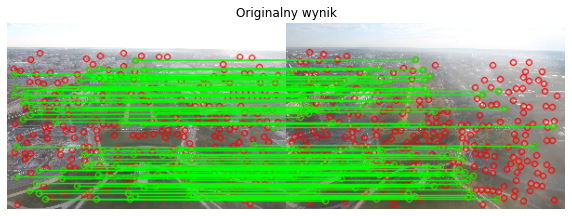

In [8]:
visualize(float_model, "data/", "Originalny wynik", (300, 200))

Evaluation 6/6 | keypoints_loss: 1.172131
Final Evaluation: keypoints_loss = 1.232949
Execution time: 0.0:0.0:0:866, processed 6 frames, throughput: 6.9271158597545135 fps.


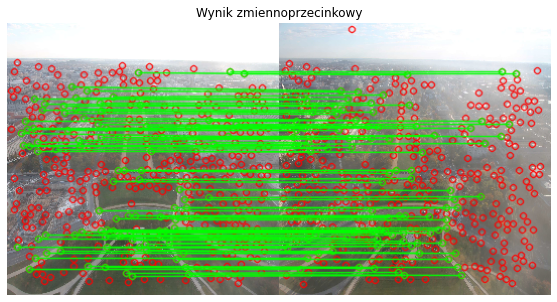

In [9]:
# You can evaluate your floating point model first 
evaluate(model, test_loader, device, model.conf)
visualize(float_model,"", "Wynik zmiennoprzecinkowy")

# 4. Kwantyzacja modelu zmiennoprzecinkowego

In [35]:
def compute_sequence(image_folder, model,float_model, tryb='show'):
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith((".png", ".jpg", ".ppm"))])
    first_image = cv2.imread(os.path.join(image_folder, image_files[0]))
    height, width, _ = first_image.shape
    past_descriptors = None
    past_keypoints = None
    for i in range(0, len(image_files), 3):
        image_file = image_files[i]
        image_path = os.path.join(image_folder, image_file)
        image, img_orig = preprocess_image(image_path, image_size)
        scores, descriptors_dense = model(torch.from_numpy(image[None, None]).float())
        scores = torch.nn.functional.softmax(scores, 1)[:, :-1]
        b, _, h, w = scores.shape
        scores = scores.permute(0, 2, 3, 1).reshape(b, h, w, 8, 8)
        scores = scores.permute(0, 1, 3, 2, 4).reshape(
            b, h * 8, w * 8
        )
        pred_th_1 = post_processing_short(scores, descriptors_dense, float_model.conf)
        descriptors = pred_th_1['descriptors'][0].cpu().detach().numpy().astype(np.float32)
        points_th = pred_th_1['keypoints'][0]
        keypoints_np = np.array(points_th)  # Konwersja do NumPy
        keypoints = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in keypoints_np]
        if past_descriptors is not None:
            m_kp1, m_kp2, matches = match_descriptors(past_keypoints, past_descriptors, keypoints, descriptors)
            H, inliers = compute_homography(m_kp1, m_kp2)
            matches = np.array(matches)[inliers.astype(bool)].tolist()

            for match in matches:
                pt1 = tuple(map(int, past_keypoints[match.queryIdx].pt))
                pt2 = tuple(map(int, keypoints[match.trainIdx].pt))
                cv2.arrowedLine(img_orig, pt2, pt1, (0, 255, 0), 1, tipLength=0.2)

        past_descriptors = descriptors
        past_keypoints = keypoints
        if tryb=='show':
            cv2.imshow("Film", img_orig)
            
            # Czekaj 30 ms na kolejny obraz (około 30 FPS)
            if cv2.waitKey(30) & 0xFF == ord('q'):
                break  # Wyjście z pętli po naciśnięciu 'q'
        else:
            cv2.imwrite("./data/matched/" + image_file, img_orig)
    if tryb=='show':
        cv2.destroyAllWindows()
        
def get_film(image_folder):
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])

    # Ustalamy rozmiar wideo na podstawie pierwszego obrazu
    first_image = cv2.imread(os.path.join(image_folder, image_files[0]))
    height, width, _ = first_image.shape

    # Nazwa pliku wynikowego wideo
    output_video = 'original.mp4'

    # Tworzymy obiekt VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Wybór kodeka
    fps = 10  # Liczba klatek na sekundę
    video_writer = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    # Dodajemy obrazy do wideo
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        video_writer.write(image)

    # Zwolnienie zasobów
    video_writer.release()

    print(f"Film zapisany jako {output_video}")

In [ ]:
def quantize(float_model:torch.nn.Module, 
             input_shape:tuple,
             quant_dir:str, 
             quant_mode:str, 
             device:torch.device,
             dataloader):
    """
    :param float_model: float model with loaded weights
    :param input_shape: shape of input(CH,W,H)
    :param quant_dir: path to directory with quantized model components
    :param quant_mode: quant_mode in ['calib', 'test'] 
    :param data_loader: data_loader - for 'calib' must be batch_size == 1
    :param evaluator: fcn/obj like: fcn(y_pred, y_ref) -> float 
    """
    tm = local_utils.TimeMeasurement("Quantization", len(dataloader))
    from pytorch_nndct.apis import torch_quantizer, dump_xmodel
    print(f"Input shape: {input_shape}")
    with tm:
        # model to device
        model = float_model.to(device)

        # Force to merge BN with CONV for better quantization accuracy
        optimize = 1

        rand_in = torch.randn(input_shape)
        print("get qunatizer start")
        try:
            quantizer = torch_quantizer(
                quant_mode, model, rand_in, output_dir=quant_dir, device=device)
        except Exception as e:
            print("exception:")
            print(e)
            return
        print("get qunatizer end")

        print("get quantized model start")
        quantized_model = quantizer.quant_model
        print("get quantized model end")

        # evaluate
        print("testing start")
        diff = evaluate(quantized_model, dataloader, device, float_model.conf)
        print(f"Testing finished: diff = {diff:.6f}")
        print("testing end")

        # export config
        if quant_mode == 'calib':
            print("export config")
            quantizer.export_quant_config()
            print("export config end")
        # export model
        if quant_mode == 'test':
            print("export xmodel")
            visualize(float_model, "", "Wynik po kwantyzacji")
            quantizer.export_xmodel(deploy_check=False, output_dir=quant_dir)
            compute_sequence("./data/rgbd_dataset_freiburg1_xyz/rgb", quantized_model, model, tryb='save')            
            print("export xmodel end")
    print(tm)

In [12]:
quantize(float_model=model, 
         input_shape=input_shape,
         quant_dir='quant_dir', # directory for quantizer results
         quant_mode='calib',
         device=device,
         dataloader=test_loader)

Input shape: (1, 1, 270, 270)
get qunatizer start

[VAIQ_NOTE]: Quant config file is empty, use default quant configuration

[VAIQ_NOTE]: Quantization calibration process start up...

[VAIQ_NOTE]: =>Quant Module is in 'cpu'.

[VAIQ_NOTE]: =>Parsing SuperPoint_short...

[VAIQ_NOTE]: Start to trace model...

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 39/39 [00:00<00:00, 486.92it/s, OpInfo: name = return_0, type = Return]                    


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(quant_dir/SuperPoint_short.py)
get qunatizer end
get quantized model start

[VAIQ_NOTE]: =>Get module with quantization.
get quantized model end
testing start


Evaluation 6/6 | keypoints_loss: 0.568306
Final Evaluation: keypoints_loss = 0.443918
Execution time: 0.0:0.0:25:855, processed 6 frames, throughput: 0.23205683752194428 fps.
Testing finished: diff = 0.443918
testing end
export config

[VAIQ_NOTE]: =>Exporting quant config.(quant_dir/quant_info.json)
export config end
Execution time: 0.0:0.0:26:284, processed 6 frames, throughput: 0.22826970543668387 fps.


Input shape: (1, 1, 270, 270)
get qunatizer start

[VAIQ_NOTE]: Quant config file is empty, use default quant configuration

[VAIQ_NOTE]: Quantization test process start up...

[VAIQ_NOTE]: =>Quant Module is in 'cpu'.

[VAIQ_NOTE]: =>Parsing SuperPoint_short...

[VAIQ_NOTE]: Start to trace model...

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 39/39 [00:00<00:00, 434.68it/s, OpInfo: name = return_0, type = Return]                    


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(quant_dir/SuperPoint_short.py)
get qunatizer end
get quantized model start

[VAIQ_NOTE]: =>Get module with quantization.
get quantized model end
testing start


Evaluation 6/6 | keypoints_loss: 0.603825
Final Evaluation: keypoints_loss = 0.591185
Execution time: 0.0:0.0:2:932, processed 6 frames, throughput: 2.045888346199963 fps.
Testing finished: diff = 0.591185
testing end
export xmodel


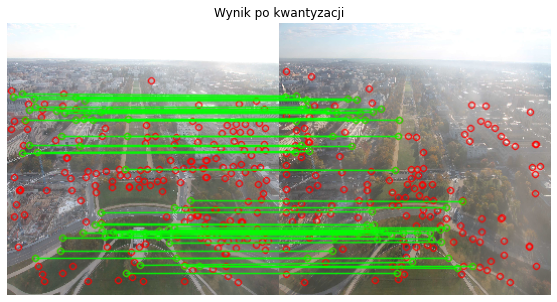


[VAIQ_NOTE]: =>Converting to xmodel ...

[VAIQ_NOTE]: =>Successfully convert 'SuperPoint_short' to xmodel.(quant_dir/SuperPoint_short_int.xmodel)
export xmodel end
Execution time: 2.0:0.0:50:688, processed 6 frames, throughput: 0.035151793226112955 fps.


In [33]:
quantize(float_model=model, 
         input_shape=input_shape,
         quant_dir='quant_dir', # directory for quantizer results
         quant_mode='test',
         device=device,
         dataloader=test_loader)

In [38]:
import cv2
import numpy as np
!pip install moviepy

from moviepy.editor import VideoFileClip, TextClip, concatenate_videoclips

# Wczytaj filmy
video1 = VideoFileClip("original.mp4")
video2 = VideoFileClip("kwantyzacja.mp4")

# Zmień rozmiar wideo, jeśli jest to konieczne (aby oba wideo miały ten sam rozmiar)
video1 = video1.resize(height=270)
video2 = video2.resize(height=270)

# Dodaj tytuł do obu wideo
title1 = TextClip("Float", fontsize=24, color='white', bg_color='black', size=video1.size)
title2 = TextClip("Kwantyzacja", fontsize=24, color='white', bg_color='black', size=video2.size)

# Ustaw czas trwania tytułu, dopasuj do długości wideo
title1 = title1.set_duration(video1.duration).set_position(('center', 0))
title2 = title2.set_duration(video2.duration).set_position(('center', 0))

# Dodaj tytuły na wideo
video1 = concatenate_videoclips([title1, video1])
video2 = concatenate_videoclips([title2, video2])

# Łączenie filmów obok siebie
final_video = concatenate_videoclips([video1, video2], method="compose")

# Zapisz wynikowy film
final_video.write_videofile("combined_video.mp4", codec='libx264', fps=24)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 692.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 576.2 kB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 823.9 kB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.0/123.0 kB 742.9 kB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 1.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 389.7 kB/s eta 0:00:000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 428.2 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 685.1 kB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 994.3 kB/s eta 0:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 kB 335.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 244.6 kB/s eta 0

OSError: MoviePy Error: creation of None failed because of the following error:

[Errno 2] No such file or directory: 'unset': 'unset'.

.This error can be due to the fact that ImageMagick is not installed on your computer, or (for Windows users) that you didn't specify the path to the ImageMagick binary in file conf.py, or that the path you specified is incorrect

Po testowaniu, należy skompilować model. Podajemy odpowiednio parametry:

- --xmodel - ścieżka do zapisanego modelu (zapisany jest w folderze podanym podczas kwantyzacji jako parametr 'quant_dir'
- --arch - podajemy plik arch.json, który znajdował się w pliku. Jest to numer (fingerprint), który określa typ DPU sprzętu docelowego
- --net_name - nazwa naszego modelu po kompilacji - dowolna
- --output_dir - folder do którego zapisany zostanie model

In [14]:
# compile model
!vai_c_xir --xmodel 'quant_dir/SuperPoint_short_int.xmodel' --arch arch.json --net_name SuperPoint_qu --output_dir build

**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: function
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
[UNILOG][INFO] Graph name: SuperPoint_short, with op num: 150
[UNILOG][INFO] Begin to compile...
[UNILOG][INFO] Total device subgraph number 4, DPU subgraph number 1
[UNILOG][INFO] Compile done.
[UNILOG][INFO] The meta json is saved to "/workspace/build/meta.json"
[UNILOG][INFO] The compiled xmodel is saved to "/workspace/build/SuperPoint_qu.xmodel"
[UNILOG][INFO] The compiled xmodel's md5sum is b35d105dc72b1a843df93d560bc463bd, and has been saved to "/workspace/build/md5sum.txt"


Teraz przejdziemy do testowania modelu na sprzęcie docelowym.

#### Wersja 1: Podłączenie do sieci
Zanim podłączysz zasilanie do Kria, podepnij kabel USB do komputera, a kabel Ethernetowy do sieci, w której znajduje się komputer.

Podłącz Kria do zasilania i poczekaj minutę, aż system się uruchomi.

Uruchom `cutecom` z `sudo`. Włącz port odpowiadający do Kria. Jeżeli pojawi się napis `kria login:` zaloguj się:

`login: ubuntu`

`hasło: Xilinx123`

Po zalogowaniu się, powinny pojawić się informacje systemowe. Nas interesuje adres `IPv4` dla `eth0`. Skopiuj go i dodaj do niego `:9090` - przykładowa wartość `192.168.1.26:9090`. Wklej to w przeglądarce. Powinien pojawić się kolejny Jupyter. Zaloguj się do niego hasłem:

`xilinx`

#### Wersja 2: Podłączenie do komputera
Zanim podłączysz zasilanie do Kria, podepnij kabel USB do komputera oraz kabel Ethernetowy pomiędzy Kria a PC. Na PC włącz ustawienia sieci `Wired Setting` -> `IPv4` -> `Shared to other computers`. Włącz zasilanie płytki.
Uruchom `cutecom` z `sudo`. Włącz port odpowiadający do Kria. Jeżeli pojawi się napis `kria login:` zaloguj się:

`login: ubuntu`

`hasło: Xilinx123`

Po zalogowaniu się, powinny pojawić się informacje systemowe. Nas interesuje adres `inet` dla `eth0`. Skopiuj go i dodaj do niego `:9090` - przykładowa wartość `10.42.0.47:9090`. Wklej to w przeglądarce. Powinien pojawić się kolejny Jupyter. Zaloguj się do niego hasłem:

`xilinx`

#### Przesyłanie plików
Stwórz nowy folder i nazwij go `PSRA_Lab`. Przenieś do niego odpowiednio pliki:
- dpu.bit, 
- dpu.hwh, 
- dpu.xclbin, 
- eval_MNIST.npz lub tak jak nazwałeś swój plik z danymi do ewaluacji
- MiniResNet_compiled.xmodel lub tak jak nazwałeś swój skompilowany plik

Można to wykonać komendą `scp`, ale łatwiej jest przeciągnąć pliki z folderu do Jupyter Notebook'a.

# UWAGA! 

Jeżeli wystąpi problem z adresami IPv4 Kria (po podłaczeniu kilku płytek do jednej sieci, każda z nich będzie miała taki sam adres), należy sprawdzić, czy działa komenda w konsoli `cutecom`:

`ifconfig`

Jeżeli nie, to należy zainstalować poprzez:

 `sudo apt install net-tools`.  
 
Po tym należy odpiąć kabel Ethernet z Kria, poczekać kilka sekund i wpisać w konsole `cutecom`:

`hostname -I`

Jeżeli konsola nie zwróci żadnego błędu oraz żadnego aresu IP to wpisz w konsole `cutecom`:

`sudo ifconfig eth0 192.168.1.x netmask 255.255.255.0`

Tutaj podany adres powinien być taki sam jak przykładowa wartość wyżej. Ustawiamy wartość `x` na inną niż była np. 123. Chcemy uniknąć konfliktu pomiędzy płytkami ale również komputerami. Po tym znowu ponawiamy:

`hostname -I`.

Powinien pojawić sie ustawiony przez nas adres. Podpinamy kabel Ethernet i uruchamiamy w przeglądarce Jupyter z ustawionym adresem IP.